In [1]:
import numpy as np
import os
import cv2
from tqdm import tqdm
from matplotlib import pyplot as plt
import torch
from super_gradients.training import models
import glob
from scipy.optimize import linear_sum_assignment, least_squares
import time
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import torchvision.transforms as T
import random

/home/yh6917/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[2023-05-17 21:13:57] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /home/yh6917/sg_logs/console.log


2023-05-17 21:13:58.428134: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-17 21:13:58.557457: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-17 21:13:59.064036: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/yh6917/.local/lib/python3.10/site-packages/cv2/../../lib64:/home/yh6917/nuws/inst

In [8]:
# read 3 frames of images
img_path1 = 'KITTI_sequence_1/image_l/000019.png'
img_path2 = 'KITTI_sequence_1/image_l/000020.png'
img_path3 = 'KITTI_sequence_1/image_l/000021.png'

img1 = cv2.imread(img_path1)
img2 = cv2.imread(img_path2)
img3 = cv2.imread(img_path3)

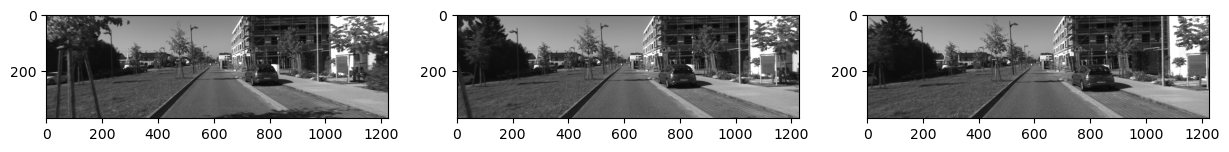

In [9]:
# show images
plt.figure(figsize=(15, 15))
plt.subplot(131)
plt.imshow(img1)
plt.subplot(132)
plt.imshow(img2)
plt.subplot(133)
plt.imshow(img3)
plt.show()

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = models.get("yolo_nas_s", pretrained_weights="coco").to(device)

def object_detection(image):
    for item in model.predict(image, conf=0.3)._images_prediction_lst:
        bboxes = item.prediction.bboxes_xyxy
        labels = item.prediction.labels
        return bboxes, labels
    return None, None

[2023-05-17 21:20:56] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.


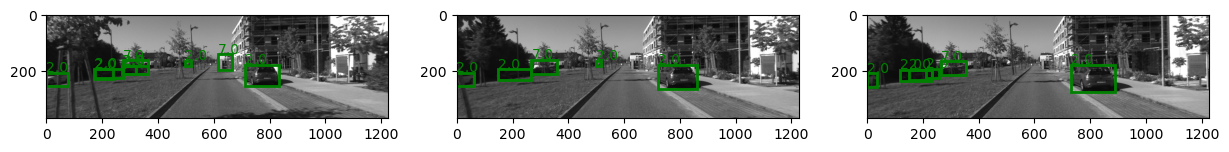

In [11]:
# detect objects in 3 frames
bboxes1, labels1 = object_detection(img1)
bboxes2, labels2 = object_detection(img2)
bboxes3, labels3 = object_detection(img3)

# show detected objects
plt.figure(figsize=(15, 15))
plt.subplot(131)
plt.imshow(img1)
for bbox, label in zip(bboxes1, labels1):
    plt.gca().add_patch(plt.Rectangle((bbox[0], bbox[1]), (bbox[2] - bbox[0]), (bbox[3] - bbox[1]), fill=False, edgecolor='g', linewidth=2))
    plt.text(bbox[0], bbox[1] - 3, str(label), color='g')
plt.subplot(132)
plt.imshow(img2)
for bbox, label in zip(bboxes2, labels2):
    plt.gca().add_patch(plt.Rectangle((bbox[0], bbox[1]), (bbox[2] - bbox[0]), (bbox[3] - bbox[1]), fill=False, edgecolor='g', linewidth=2))
    plt.text(bbox[0], bbox[1] - 3, str(label), color='g')
plt.subplot(133)
plt.imshow(img3)
for bbox, label in zip(bboxes3, labels3):
    plt.gca().add_patch(plt.Rectangle((bbox[0], bbox[1]), (bbox[2] - bbox[0]), (bbox[3] - bbox[1]), fill=False, edgecolor='g', linewidth=2))
    plt.text(bbox[0], bbox[1] - 3, str(label), color='g')
plt.show()

In [9]:


# Load a pre-trained version of Fast-RCNN that's been trained on COCO dataset
model = fasterrcnn_resnet50_fpn(pretrained=True)

# Set the model in evaluation mode
model.eval()

# Load an image 
from PIL import Image
image = Image.open("KITTI_sequence_1/image_l/000000.png")

# Transform the image

transform = T.Compose([T.ToTensor()]) # Defing PyTorch Transform
image = transform(image) # Apply the transform to the image

# Put the image on the GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
image = image.to(device)

# Add a batch dimension
image = image.unsqueeze(0) 

# Perform the object detection
with torch.no_grad():
    prediction = model(image)

print(prediction)


/home/yh6917/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yh6917/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /home/yh6917/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:12<00:00, 13.4MB/s] 


[{'boxes': tensor([[ 709.3822,  168.6832,  845.3510,  255.5047],
        [ 280.1543,  188.4157,  324.6894,  211.4205],
        [ 645.8456,  170.9471,  687.1113,  201.5089],
        [1175.9900,  167.0311, 1222.1089,  243.4905],
        [1088.7877,  192.1835, 1121.4727,  243.3720],
        [1099.1660,  224.0766, 1135.7511,  252.2474],
        [ 134.6209,  219.9553,  286.4773,  267.4872],
        [1067.2056,  219.4475, 1090.3342,  252.4549],
        [1091.9342,  205.4617, 1136.2721,  250.8624],
        [ 343.0121,  177.9419,  408.8940,  204.6883],
        [ 385.2106,  176.4450,  411.0651,  200.1884],
        [ 414.0851,  177.1151,  426.2455,  196.2976],
        [1087.0151,  216.6491, 1103.6394,  249.0685],
        [ 604.6561,  165.4670,  609.2046,  178.2327],
        [1174.3450,  161.9480, 1223.7443,  240.4804],
        [1063.9441,  196.9680, 1094.3190,  251.0717],
        [ 601.8293,  165.6140,  607.0205,  178.0027],
        [1110.0497,  187.3434, 1142.9231,  244.3123],
        [1067.779

In [10]:
# filter fast-rcnn prediction to only show those that have probability over 0.6
def filter_prediction(prediction, conf=0.6):
    bboxes = []
    labels = []
    for i in range(len(prediction[0]['boxes'])):
        if prediction[0]['scores'][i] > conf:
            bboxes.append(prediction[0]['boxes'][i])
            labels.append(prediction[0]['labels'][i])
    return bboxes, labels

bboxes, labels = filter_prediction(prediction)

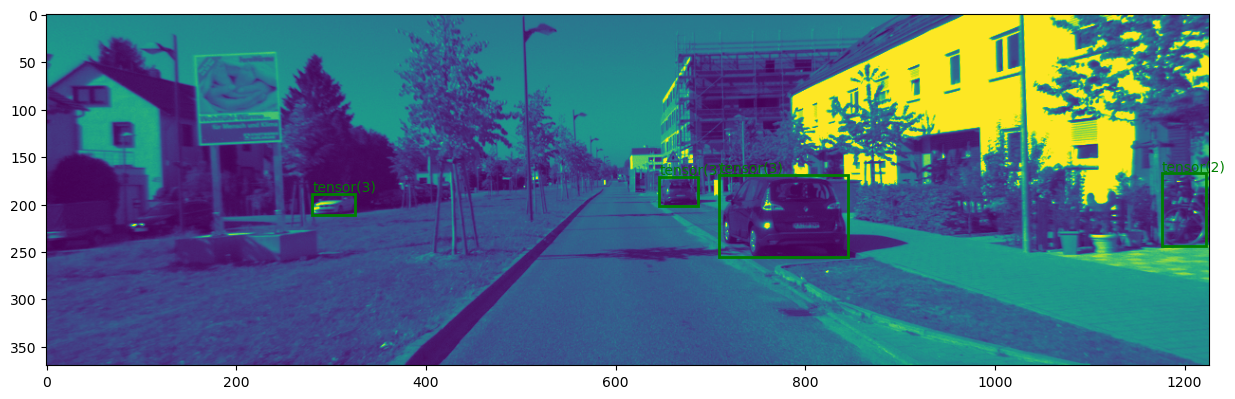

In [14]:
# show detected objects
plt.figure(figsize=(15, 15))
plt.imshow(image.squeeze(0).permute(1, 2, 0).cpu().numpy())
for bbox, label in zip(bboxes, labels):
    plt.gca().add_patch(plt.Rectangle((bbox[0], bbox[1]), (bbox[2] - bbox[0]), (bbox[3] - bbox[1]), fill=False, edgecolor='g', linewidth=2))
    plt.text(bbox[0], bbox[1] - 3, str(label), color='g')
plt.show()

In [19]:
def compute_iou(box1, box2):
    """
    Computes IoU (Intersection over Union) between two bounding boxes
    IoU is a metric for evaluating simularity between two bounding boxes
    IoU is a value between 0 and 1, where 1 means the two bounding boxes are identical
    """
    x1, y1, x2, y2 = box1
    x3, y3, x4, y4 = box2
    x5, y5, x6, y6 = (max(x1, x3), max(y1, y3), min(x2, x4), min(y2, y4))
    if x5 > x6 or y5 > y6:
        return 0
    else:
        intersection = (x6 - x5) * (y6 - y5)
        union = (x2 - x1) * (y2 - y1) + (x4 - x3) * (y4 - y3) - intersection
        return intersection / union

In [20]:
def assign_objects(bboxes1, bboxes2, labels1, labels2):
    cost_matrix = np.zeros((len(bboxes1), len(bboxes2)))

    for i, bbox1 in enumerate(bboxes1):
        for j, bbox2 in enumerate(bboxes2):
            if labels1[i] == labels2[j]:
                iou = compute_iou(bbox1, bbox2)
                cost_matrix[i, j] = 1 - iou  # Convert IOU to cost by taking 1 - iou

    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    matches = []
    for i, j in zip(row_ind, col_ind):
        if cost_matrix[i, j] < (1 - 0.5):
            matches.append((i, j))

    return matches

In [21]:
matches_1_2 = assign_objects(bboxes1, bboxes2, labels1, labels2)
matches_1_2

[(0, 0), (1, 1)]

In [22]:
object_library = {}

In [29]:
def compare_with_existing_objects(object_library, bbox):
    all_iou = []
    all_keys = []
    for key, value in object_library.items():
        iou = compute_iou(value, bbox)
        all_iou.append(iou)
        all_keys.append(key)

    if len(all_iou) > 0:
        max_iou = max(all_iou)
        max_iou_index = all_iou.index(max_iou)
        max_iou_key = all_keys[max_iou_index]

        if max_iou > 0.5:
            return max_iou_key
    return None

In [30]:
def update_object_library(object_library, bbox):
    key = compare_with_existing_objects(object_library, [bbox])
    if key is None:
        key = len(object_library)
        object_library[key] = None
    object_library[key] = bbox
    return object_library

In [ ]:
def find_transformation(object_library, key, new_bbox):
    

In [31]:
class VisualOdometryWithObjects():
    def __init__(self, data_path, feature_method="orb", match_threshold=0.5, iou_threshold=0.5, random_window_size=150):
        self.K, self.P = self._load_calib(os.path.join(data_path, 'calib.txt'))
        self.groundtruth_poses = self._load_poses(os.path.join(data_path, 'poses.txt'))
        self.images = self._load_images(os.path.join(data_path, 'image_l'))
        self.feature_method = feature_method
        self.match_threshold = match_threshold
        self.iou_threshold = iou_threshold
        if feature_method == "orb":
            self.feature_detector = cv2.ORB_create(3000)
            FLANN_INDEX_LSH = 6
            index_params = dict(algorithm=FLANN_INDEX_LSH, table_number=6, key_size=12, multi_probe_level=1)
            search_params = dict(checks=50)
        elif feature_method == "sift":
            self.feature_detector = cv2.SIFT_create()
            FLANN_INDEX_KDTREE = 1
            index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
            search_params = dict(checks=50)
        else:
            raise ValueError("Feature method not supported")
        self.flann = cv2.FlannBasedMatcher(indexParams=index_params, searchParams=search_params)

        # object detection related setup
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model = models.get("yolo_nas_s", pretrained_weights="coco").to(self.device)
        self.last_bboxes = None
        self.last_labels = None

        self.random_window_size = random_window_size

    @staticmethod
    def _load_calib(filepath):
        with open(filepath, 'r') as f:
            params = np.fromstring(f.readline(), dtype=np.float64, sep=' ')
            P = np.reshape(params, (3, 4))
            K = P[0:3, 0:3]
        return K, P
    
    @staticmethod
    def _load_poses(filepath):
        poses = []
        with open(filepath, 'r') as f:
            for line in f.readlines():
                T = np.fromstring(line, dtype=np.float64, sep=' ')
                T = T.reshape(3, 4)
                poses.append(T)
        return np.array(poses)

    @staticmethod
    def _load_images(filepath):
        images = []
        for filename in sorted(os.listdir(filepath)):
            img = cv2.imread(os.path.join(filepath, filename))
            images.append(img)
        return images
    
    @staticmethod
    def _form_transf(R, t):
        T = np.eye(4)
        T[:3, :3] = R
        T[:3, 3] = t
        return T
    
    def get_matches(self, i, curr_bboxes):
        # only extract features from where objects are detected
        # for image i-1, extract features from self.last_bboxes
        kp1 = []
        des1 = []
        # if any value in self.last_bboxes or curr_bboxes are not within [0, 1225], set them to 0 or 1225
        self.last_bboxes = np.clip(self.last_bboxes, 0, 1225)
        curr_bboxes = np.clip(curr_bboxes, 0, 1225)
        # convert to int
        self.last_bboxes = self.last_bboxes.astype(int)
        curr_bboxes = curr_bboxes.astype(int)

        for bbox in self.last_bboxes:
            bbox_img = self.images[i-1][bbox[1]:bbox[3], bbox[0]:bbox[2]]
            # print(bbox_img.shape)
            kp, des = self.feature_detector.detectAndCompute(bbox_img, None)
            # shift kp to global coordinates
            for k in kp:
                k.pt = (k.pt[0] + bbox[0], k.pt[1] + bbox[1])
            if len(kp) == 0:
                continue
            kp1.extend(kp)
            des1.extend(des)
        # for image i, extract features from curr_bboxes
        kp2 = []
        des2 = []
        for bbox in curr_bboxes:
            # print(bbox)
            bbox_img = self.images[i][bbox[1]:bbox[3], bbox[0]:bbox[2]]
            kp, des = self.feature_detector.detectAndCompute(bbox_img, None)
            # shift kp to global coordinates
            for k in kp:
                k.pt = (k.pt[0] + bbox[0], k.pt[1] + bbox[1])
            if len(kp) == 0:
                continue
            kp2.extend(kp)
            des2.extend(des)
        if self.feature_method == "orb":
            matches = self.flann.knnMatch(np.array(des1), np.array(des2), k=2)
        elif self.feature_method == "sift":
            matches = self.flann.knnMatch(np.array(des1).astype(np.float32), np.array(des2).astype(np.float32), k=2)
        else:
            raise ValueError("Feature method not supported")
        # check if matches are good
        if len(matches) == 0:
            matches, kp1, kp2 = self.random_boxes(i)
        good_matches = []
        for m, n in matches:
            if m.distance < self.match_threshold * n.distance:
                good_matches.append(m)
        if len(good_matches) < 10:
            matches, kp1, kp2 = self.random_boxes(i)
            good_matches = []
            for m, n in matches:
                if m.distance < self.match_threshold * n.distance:
                    good_matches.append(m)
        q1 = np.array([kp1[m.queryIdx].pt for m in good_matches])
        q2 = np.array([kp2[m.trainIdx].pt for m in good_matches])
        return q1, q2
    
    def random_boxes(self, i):
        # randomly select a few bounding boxes from the image and extract features
        random_bboxes = []
        for _ in range(10):
            rand_x = np.random.randint(0, self.images[i].shape[1] - self.random_window_size)
            rand_y = np.random.randint(0, self.images[i].shape[0] - self.random_window_size)
            random_bboxes.append([rand_x, rand_y, rand_x+self.random_window_size, rand_y+self.random_window_size])
        kp1 = []
        des1 = []
        kp2 = []
        des2 = []
        for bbox in random_bboxes:
            bbox_img = self.images[i-1][bbox[1]:bbox[3], bbox[0]:bbox[2]]
            kp, des = self.feature_detector.detectAndCompute(bbox_img, None)
            # shift kp to global coordinates
            for k in kp:
                k.pt = (k.pt[0] + bbox[0], k.pt[1] + bbox[1])
            if len(kp) == 0:
                continue
            kp1.extend(kp)
            des1.extend(des)
            bbox_img = self.images[i][bbox[1]:bbox[3], bbox[0]:bbox[2]]
            kp, des = self.feature_detector.detectAndCompute(bbox_img, None)
            # shift kp to global coordinates
            for k in kp:
                k.pt = (k.pt[0] + bbox[0], k.pt[1] + bbox[1])
            if len(kp) == 0:
                continue
            kp2.extend(kp)
            des2.extend(des)
        if self.feature_method == "orb":
            matches = self.flann.knnMatch(np.array(des1), np.array(des2), k=2)
        elif self.feature_method == "sift":
            matches = self.flann.knnMatch(np.array(des1).astype(np.float32), np.array(des2).astype(np.float32), k=2)
        return matches, kp1, kp2
    
    def get_pose(self, q1, q2):
        # Essential, mask = cv2.findEssentialMat(q1, q2, self.K, cv2.RANSAC, 0.999, 1.0)
        Essential, mask = cv2.findEssentialMat(q1, q2, self.K)
        R, t = self.decompose(Essential, q1, q2)
        return self._form_transf(R, t)
    
    def decompose(self, Essential, q1, q2):
        R1, R2, t = cv2.decomposeEssentialMat(Essential)
        T1 = self._form_transf(R1,np.ndarray.flatten(t))
        T2 = self._form_transf(R2,np.ndarray.flatten(t))
        T3 = self._form_transf(R1,np.ndarray.flatten(-t))
        T4 = self._form_transf(R2,np.ndarray.flatten(-t))
        transformations = [T1, T2, T3, T4]
        K = np.concatenate(( self.K, np.zeros((3,1)) ), axis = 1)
        projections = [K @ T1, K @ T2, K @ T3, K @ T4]
        np.set_printoptions(suppress=True)
        positives = []
        for P, T in zip(projections, transformations):
            hom_Q1 = cv2.triangulatePoints(self.P, P, q1.T, q2.T)
            hom_Q2 = T @ hom_Q1
            Q1 = hom_Q1[:3, :] / hom_Q1[3, :]
            Q2 = hom_Q2[:3, :] / hom_Q2[3, :]  

            total_sum = sum(Q2[2, :] > 0) + sum(Q1[2, :] > 0)
            """
            relative_scale = np.mean(np.linalg.norm(Q1.T[:-1] - Q1.T[1:], axis=-1)/
                                     np.linalg.norm(Q2.T[:-1] - Q2.T[1:], axis=-1))
            """
            relative_scale = np.mean(np.linalg.norm(Q1.T[:-1] - Q1.T[1:], axis=-1) /
                                     (np.linalg.norm(Q2.T[:-1] - Q2.T[1:], axis=-1) + 1e-8))
            positives.append(total_sum + relative_scale)
        max = np.argmax(positives)
        if (max == 2):
            return R1, np.ndarray.flatten(-t)
        elif (max == 3):
            return R2, np.ndarray.flatten(-t)
        elif (max == 0):
            return R1, np.ndarray.flatten(t)
        elif (max == 1):
            return R2, np.ndarray.flatten(t)
    
    def get_objects(self, i):
        # prediction = self.model.predict(self.images[i])
        for item in self.model.predict(self.images[i], conf=0.3)._images_prediction_lst:
            bboxes = item.prediction.bboxes_xyxy
            labels = item.prediction.labels
            return bboxes, labels
        return None, None
    
    def match_objects(self, bboxes1, bboxes2, labels1, labels2):
        matches = []
        for i, bbox1 in enumerate(bboxes1):
            for j, bbox2 in enumerate(bboxes2):
                if labels1[i] == labels2[j]:
                    box1 = bbox1
                    box2 = bbox2
                    iou = self.compute_iou(box1, box2)
                    if iou > self.iou_threshold:
                        matches.append((i, j))
        return matches
    
    def compute_iou(self, box1, box2):
        """
        Computes IoU (Intersection over Union) between two bounding boxes
        IoU is a metric for evaluating simularity between two bounding boxes
        IoU is a value between 0 and 1, where 1 means the two bounding boxes are identical
        """
        x1, y1, x2, y2 = box1
        x3, y3, x4, y4 = box2
        x5, y5, x6, y6 = (max(x1, x3), max(y1, y3), min(x2, x4), min(y2, y4))
        if x5 > x6 or y5 > y6:
            return 0
        else:
            intersection = (x6 - x5) * (y6 - y5)
            union = (x2 - x1) * (y2 - y1) + (x4 - x3) * (y4 - y3) - intersection
            return intersection / union

    def get_trajectory(self):
        truth_path = []
        estimated_path = []
        # time_taken_for_feature = []
        # time_taken_for_object = []
        # time_taken_for_fastrcnn = []
        for i, true_pose in enumerate(tqdm(self.groundtruth_poses, unit="frame")):
            if i == 0:
                current_pose = true_pose
                self.last_bboxes, self.last_labels = self.get_objects(i)
            else:
                # time2 = time.time()
                # object detection related code
                bboxes, labels = self.get_objects(i)

                q1, q2 = self.get_matches(i, bboxes)
                estimated_pose_from_feature = self.get_pose(q1, q2)

                estimated_pose = estimated_pose_from_feature
                
                self.last_bboxes = bboxes
                self.last_labels = labels

                current_pose = np.matmul(current_pose, np.linalg.inv(estimated_pose))
            truth_path.append(true_pose)
            estimated_path.append(current_pose)
        return truth_path, estimated_path

    def plot_trajectory(self, truth_path, estimated_path):
        truth_path = np.array(truth_path)
        estimated_path = np.array(estimated_path)
        fig = plt.figure()
        # set limit on x axis
        plt.xlim(-10, 10)
        plt.plot(truth_path[:, 0, 3], truth_path[:, 2, 3], label='Ground Truth')
        plt.plot(estimated_path[:, 0, 3], estimated_path[:, 2, 3], label='Estimated')
        plt.legend()
        plt.show()

    def plot_error(self, truth_path, estimated_path):
        truth_path = np.array(truth_path)
        estimated_path = np.array(estimated_path)
        error = np.linalg.norm(truth_path[:, :3, 3] - estimated_path[:, :3, 3], axis=1)
        plt.plot(error)
        plt.show()

In [32]:
data_path = 'KITTI_sequence_1'
vo = VisualOdometryWithObjects(data_path, feature_method='sift', match_threshold=0.5)
truth_path, estimated_path = vo.get_trajectory()
vo.plot_trajectory(truth_path, estimated_path)
vo.plot_error(truth_path, estimated_path)

[2023-05-17 21:51:04] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
 20%|█▉        | 10/51 [00:03<00:14,  2.82frame/s]

IndexError: list index out of range

 20%|█▉        | 10/51 [00:03<00:16,  2.55frame/s]


In [26]:
img1.shape

(370, 1226, 3)

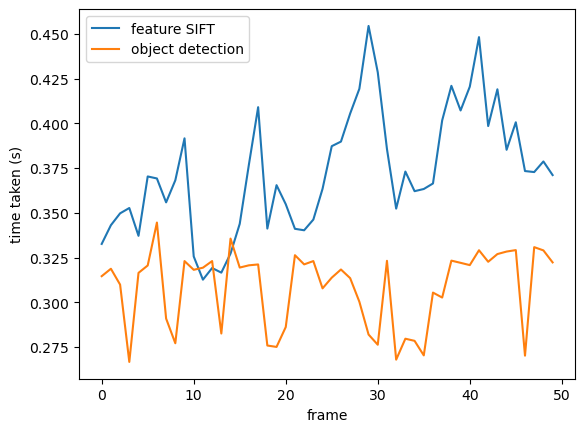

In [26]:
# plot time_taken_for_feature and time_taken_for_object
plt.plot(time_taken_for_feature, label='feature SIFT')
plt.plot(time_taken_for_object, label='object detection')
# label axis
plt.xlabel('frame')
plt.ylabel('time taken (s)')
plt.legend()
plt.show()

In [8]:
# find average time taken for feature and object detection
print('Average time taken for feature detection: ', np.mean(time_taken_for_feature))
print('Average time taken for object detection: ', np.mean(time_taken_for_object))

Average time taken for feature detection:  0.38566405296325684
Average time taken for object detection:  0.3065249109268188
